In [1]:
# ! pip install tensorboard

In [2]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import MultivariateNormal
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import time
import os

Improvement
Read the following for improving the code  
https://medium.com/@z4xia/coding-ppo-from-scratch-with-pytorch-part-4-4-4e21f4a63e5c

Example 1 - unfinished

In [4]:
# Networks

class feedForwardNN(nn.Module):
    def __init__(self, inDim, outDim):
        super(feedForwardNN, self).__init__()
        
        self.layer1 = nn.Linear(inDim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, outDim)
        
    def forward(self, x):
        # x should be a tensor
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        
        return x

In [5]:
class PPO:
    def __init__(self, env):
        # Define the hyper parameters
        self._initHyperParameters()
        
        # Extract environment information
        self.env = env
        self.obsDim = env.observation_space.shape[0]
        self.actDim = env.action_space.shape[0]
        
        # Define the networks
        self.actor = feedForwardNN(self.obsDim, self.actDim)
        self.critic = feedForwardNN(self.obsDim, 1)
        
        # Create our variable for the matrix.
        # Note that I chose 0.5 for stdev arbitrarily.
        self.cov_var = torch.full(size=(self.actDim,), fill_value=0.5)
        self.cov_mat = torch.diag(self.cov_var)
        
        # The optimizer
        self.lr = 0.005
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=self.lr)
    
    def _initHyperParameters(self):
        # The default hyper parameters of the PPO strategy
        self.timeStepsPerBatch = 4800
        self.maxTimeStepsPerEpisode = 1600
        self.gamma = 0.95
        self.n_updates_per_iteration = 5
        self.clip = 0.2
        self.lr = 0.005
    
    def getActions(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        mean = self.actor(obs)
        dist = MultivariateNormal(mean, self.cov_mat)
        action = dist.sample()
        logProb = dist.log_prob(action)
        
        return action.detach().numpy(), logProb.detach()
    
    def rollout(self):
        # The data collector
        batchObs = []
        batchActions = []
        batchLogProbs = []
        cumEpisodeRewards = []
        batchRewards = []
        batchRewardsToGo = []
        batchEpisodeLengths = []
        
        t = 0
        while t < self.timeStepsPerBatch:
            # Rewards per episode
            episodeRewards = []
            
            obs, info = self.env.reset()
            
            terminated, truncated = False, False
            
            for tEpisode in range(self.maxTimeStepsPerEpisode):
                t += 1
                
                # Collect observations
                batchObs.append(obs)
                
                action, logProb = self.getActions(obs)
                obs, reward, terminated, truncated, info = self.env.step(action)
                
                episodeRewards.append(reward)
                batchActions.append(action)
                batchLogProbs.append(logProb)
                
                if terminated or truncated: break
            
            batchEpisodeLengths.append(tEpisode + 1)
            batchRewards.append(episodeRewards)
            cumEpisodeRewards.append(np.array(episodeRewards).sum())
        
        batchObs = torch.tensor(batchObs, dtype=torch.float32)
        batchActions = torch.tensor(batchActions, dtype=torch.float32)
        batchLogProbs = torch.tensor(batchLogProbs, dtype=torch.float32)
        
        batchRewardsToGo = self.computeRewardsToGo(batchRewards)
        
        return batchObs, batchActions, batchLogProbs, batchRewardsToGo, batchEpisodeLengths, cumEpisodeRewards
    
    def computeRewardsToGo(self, batchRewards):
        # The rewards-to-go per episode in each batch
        batchRewardsToGo = []
        
        for episodeRewards in reversed(batchRewards):
            discountedReward = 0
            
            for rew in reversed(episodeRewards):
                discountedReward = rew + discountedReward * self.gamma
                batchRewardsToGo.insert(0, discountedReward)
        
        batchRewardsToGo = torch.tensor(batchRewardsToGo, dtype=torch.float32)
        
        return batchRewardsToGo
    
    def learn(self, totalSteps):
        rewardsMem = []
        criticLossMem = []
        actorLossMem = []
        
        t = 0
        while t < totalSteps:
            # Collect data
            batchObs, batchActions, batchLogProbs, batchRewardsToGo, batchEpisodeLengths, batchRewards = self.rollout()
            rewardsMem.extend(batchRewards)
            
            # Increment time step
            t += np.sum(batchEpisodeLengths)
            
            # Calculate V_{phi,k}
            V, _ = self.evaluate(batchObs, batchActions)
            
            # Calculate A_{phi,k}
            advantage = batchRewardsToGo - V.detach()
            
            # Normalize the advantage
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10)
            
            for i in range(self.n_updates_per_iteration):
                V, currentLogProbs = self.evaluate(batchObs, batchActions)
                
                ratio = torch.exp(currentLogProbs - batchLogProbs)
                
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1 - self.clip, 1 + self.clip) * advantage
                
                # Calculate the network losses
                actorLoss = -torch.min(surr1, surr2).mean()
                criticLoss = nn.MSELoss()(V, batchRewardsToGo)
                actorLossMem.append(actorLoss.item())
                criticLossMem.append(criticLoss.item())
                
                # Calculate gradients and perform backward propagation for actor network
                self.actor_optim.zero_grad()
                actorLoss.backward()
                self.actor_optim.step()
                
                # Calculate gradients and perform backward propagation for critic network
                self.critic_optim.zero_grad()
                criticLoss.backward()
                self.critic_optim.step()
            print(f"Step: {t} | AVG Actor Loss: {np.array(actorLossMem[-100:-1]).mean():.5f} | AVG Critic Loss: {np.array(criticLossMem[-100:-1]).mean():.2f} | AVG EP Reward: {np.array(rewardsMem[-100:-1]).mean():.2f}")
        
        return rewardsMem, actorLossMem, criticLossMem

    def evaluate(self, batchObs, batchActs):
        # Query critic network for a value V for each obs in batchObs
        V = self.critic(batchObs).squeeze()
        
        distMean = self.actor(batchObs)
        actionDist = MultivariateNormal(distMean, self.cov_mat)
        logProbs = actionDist.log_prob(batchActs)
        
        return V, logProbs

    def calculateAdvantage_GAE(self):
        # TODO
        pass

In [6]:
env = gym.make('Pendulum-v1')
model = PPO(env)
rewards, actorLoss, criticLoss = model.learn(150000)

C:\Users\Spino.shop\AppData\Local\Temp\ipykernel_4784\2613710615.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batchObs = torch.tensor(batchObs, dtype=torch.float32)


Step: 4800 | AVG Actor Loss: 0.01326 | AVG Critic Loss: 14669.84 | AVG EP Reward: -1263.16
Step: 9600 | AVG Actor Loss: 0.00765 | AVG Critic Loss: 14659.90 | AVG EP Reward: -1281.88
Step: 14400 | AVG Actor Loss: 0.00495 | AVG Critic Loss: 14625.70 | AVG EP Reward: -1312.08
Step: 19200 | AVG Actor Loss: 0.00356 | AVG Critic Loss: 14200.20 | AVG EP Reward: -1311.91
Step: 24000 | AVG Actor Loss: 0.00273 | AVG Critic Loss: 13544.68 | AVG EP Reward: -1310.67
Step: 28800 | AVG Actor Loss: 0.00222 | AVG Critic Loss: 12522.26 | AVG EP Reward: -1306.21
Step: 33600 | AVG Actor Loss: 0.00184 | AVG Critic Loss: 11497.58 | AVG EP Reward: -1285.21
Step: 38400 | AVG Actor Loss: 0.00152 | AVG Critic Loss: 10518.86 | AVG EP Reward: -1257.98
Step: 43200 | AVG Actor Loss: 0.00125 | AVG Critic Loss: 9874.03 | AVG EP Reward: -1284.42
Step: 48000 | AVG Actor Loss: 0.00108 | AVG Critic Loss: 9339.04 | AVG EP Reward: -1281.96
Step: 52800 | AVG Actor Loss: 0.00095 | AVG Critic Loss: 8826.14 | AVG EP Reward: -1

KeyboardInterrupt: 

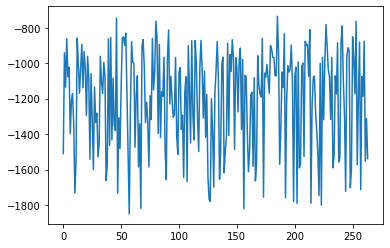

In [ ]:
# plt.plot([loss.item() for loss in actorLoss])
plt.plot(rewards)